In [1]:
import os
import pathlib
import torch
import pandas as pd
import numpy as np
from torch.utils import data
import librosa
import matplotlib.pyplot as plt
import cv2
import PIL
import PIL.Image as Image
import torchvision.transforms as transforms

In [40]:
class UrbanSound8kDataset(data.dataset.Dataset):
    def __init__(self, root, csv_file, mode='train', transform=None):
        super(UrbanSound8kDataset, self).__init__()
        self.root = root
        self.csv_file = csv_file
        self.mode = mode
        self.df = pd.read_csv(self.csv_file)
        self.do_train_valid_split()
        self.transform = transform
        
    def do_train_valid_split(self):
        self.train_df = self.df[np.logical_and(self.df['fold'] >= 1, self.df['fold'] <= 8)]
        self.train_df = self.train_df.reset_index(drop=True)
        
        self.valid_df = self.df[np.logical_and(self.df['fold'] >= 9, self.df['fold'] <= 10)]
        self.valid_df = self.valid_df.reset_index(drop=True)
        
        if self.mode is 'train':
            self.df = self.train_df
        else:
            self.df = self.valid_df
        

    def _classes(self):
        classes = self.df['class'].unique()
        classes.sort()
        classes = list(classes)
        return classes
    
    def class_to_idx(self):
        classes = self._classes()
        cti = {}
        for idx, c in enumerate(classes):
            cti.update({c: idx})
        return cti
    
    def idx_to_class(self):
        classes = self._classes()
        cti = {}
        for idx, c in enumerate(classes):
            cti.update({idx: c})
        return cti
    
    def __len__(self):
        return len(df)
    
    def build_path(self, idx):
        fold = f"fold{str(self.df['fold'][idx])}"
        filename = self.df['slice_file_name'][idx]
        path = os.path.join(self.root, fold, filename)
        return path
    
    def _image_scale(self, x, xmin=0, xmax=255):
        omin, omax = x.min(), x.max()
        opercent = (x - omin) / (omax - omin)
        n_x = ((xmax - xmin) * opercent) + xmin
        return np.uint8(n_x)
    
    def _load_audio(self, path):
        y, sr = librosa.load(path)
        audio_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        audio_spec_db = librosa.power_to_db(audio_mfcc, ref=np.max)
        image = self._image_scale(audio_spec_db, xmin=-1, xmax=1)
        return image
    
    def __getitem__(self, idx):
        path = self.build_path(idx)
        image = self._load_audio(path)
        classes = int(self.df['classID'][idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, classes
    

In [41]:
class NumpyToPIL(object):
    def __init__(self, to_rgb=True):
        super(NumpyToPIL, self).__init__()
        self.to_rgb = to_rgb
            
    def __call__(self, img):
        image = Image.fromarray(np.uint8(img))
        if self.to_rgb:
            image = image.convert("RGB")
        return image

In [42]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_tmft = transforms.Compose([
    NumpyToPIL(),
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    normalize,
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : children_playing


torch.Size([3, 224, 224])

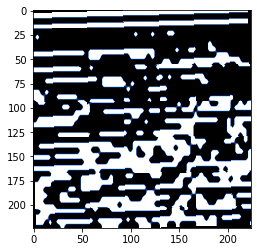

In [43]:
train_dataset = UrbanSound8kDataset(root = '/data/UrbanSound8K/audio',
                              csv_file = '/data/UrbanSound8K/metadata/UrbanSound8K.csv',
                              mode='train',
                              transform=train_tmft)
image, classes = train_dataset[1]
print(f'classes : {train_dataset.idx_to_class()[classes]}')
plt.imshow(image.permute(1,2,0), cmap='hot')
image.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : car_horn


torch.Size([3, 224, 224])

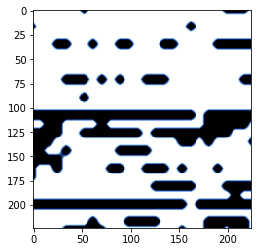

In [46]:
valid_tmft = transforms.Compose([
    NumpyToPIL(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

valid_dataset = UrbanSound8kDataset(root = '/data/UrbanSound8K/audio',
                              csv_file = '/data/UrbanSound8K/metadata/UrbanSound8K.csv',
                              mode='valid',
                              transform=valid_tmft)
# valid_dataset.valid_df
image, classes = valid_dataset[0]
print(f'classes : {valid_dataset.idx_to_class()[classes]}')
plt.imshow(image.permute(1,2,0), cmap='hot')
image.shape

In [45]:
df[np.logical_and(df['fold'] >= 1,df['fold'] <= 8)]

NameError: name 'df' is not defined